In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataverse-files/h09.edf
/kaggle/input/dataverse-files/h07.edf
/kaggle/input/dataverse-files/s10.edf
/kaggle/input/dataverse-files/s08.edf
/kaggle/input/dataverse-files/s06.edf
/kaggle/input/dataverse-files/h04.edf
/kaggle/input/dataverse-files/MANIFEST.TXT
/kaggle/input/dataverse-files/h01.edf
/kaggle/input/dataverse-files/s01.edf
/kaggle/input/dataverse-files/h13.edf
/kaggle/input/dataverse-files/s09.edf
/kaggle/input/dataverse-files/s05.edf
/kaggle/input/dataverse-files/h10.edf
/kaggle/input/dataverse-files/s02.edf
/kaggle/input/dataverse-files/s07.edf
/kaggle/input/dataverse-files/s14.edf
/kaggle/input/dataverse-files/s13.edf
/kaggle/input/dataverse-files/h14.edf
/kaggle/input/dataverse-files/s04.edf
/kaggle/input/dataverse-files/h12.edf
/kaggle/input/dataverse-files/h05.edf
/kaggle/input/dataverse-files/h03.edf
/kaggle/input/dataverse-files/s11.edf
/kaggle/input/dataverse-files/h02.edf
/kaggle/input/dataverse-files/h08.edf
/kaggle/input/dataverse-files/h11.edf
/kaggle

In [2]:
from glob import glob
import os
import mne
import numpy as np
from scipy import stats
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
all_file_path = glob('/kaggle/input/dataverse-files/*.edf')
print(f"Total files: {len(all_file_path)}")


Total files: 28


In [4]:
healthy_file_path = [f for f in all_file_path if 'h' in f.split('/')[-1]]
patient_file_path = [f for f in all_file_path if 's' in f.split('/')[-1]]
print(f"Healthy: {len(healthy_file_path)}, Patient: {len(patient_file_path)}")

Healthy: 14, Patient: 14


In [5]:
def read_data(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.set_eeg_reference()
    raw.filter(l_freq=0.5, h_freq=45)
    epochs = mne.make_fixed_length_epochs(raw, duration=25, overlap=0)
    return epochs.get_data()  # shape: (n_epochs, n_channels, n_times)


In [6]:
def mean(data): return np.mean(data, axis=-1)
def std(data): return np.std(data, axis=-1)
def ptp(data): return np.ptp(data, axis=-1)
def var(data): return np.var(data, axis=-1)
def minim(data): return np.min(data, axis=-1)
def maxim(data): return np.max(data, axis=-1)
def argminim(data): return np.argmin(data, axis=-1)
def argmaxim(data): return np.argmax(data, axis=-1)
def mean_square(data): return np.mean(data**2, axis=-1)
def rms(data): return np.sqrt(np.mean(data**2, axis=-1))
def abs_diffs_signal(data): return np.sum(np.abs(np.diff(data, axis=-1)), axis=-1)
def skewness(data): return stats.skew(data, axis=-1)
def kurtosis(data): return stats.kurtosis(data, axis=-1)


In [7]:
def concatenate_features(data):
    return np.stack((
        mean(data), std(data), ptp(data), var(data), minim(data), maxim(data),
        argminim(data), argmaxim(data), mean_square(data), rms(data),
        abs_diffs_signal(data), skewness(data), kurtosis(data)
    ), axis=-1)


In [8]:
%%capture
control_epochs_array = [read_data(f) for f in healthy_file_path]
patients_epochs_array = [read_data(f) for f in patient_file_path]

control_labels = [np.zeros(len(arr), dtype=int) for arr in control_epochs_array]
patient_labels = [np.ones(len(arr), dtype=int) for arr in patients_epochs_array]

epochs_array = np.vstack(control_epochs_array + patients_epochs_array)
epochs_labels = np.hstack(control_labels + patient_labels)

features = np.array([concatenate_features(epoch) for epoch in tqdm(epochs_array)])
print(f"Features shape: {features.shape}")  # (n_samples, n_channels, n_features)


In [52]:
# Assuming features is of shape (n_samples, n_channels, n_features)
n_samples, n_channels, n_features = features.shape
X = features.reshape(n_samples, n_channels * n_features)
y = epochs_labels  # or your label array

RANDOM FOREST

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest: {accuracy:.2f}")


Random Forest: 0.93


In [12]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_model, random_state=42).fit(X_test, y_test)
feature_importances = perm.feature_importances_

num_channels, num_stats = features.shape[1], features.shape[2]
reshaped_importance = feature_importances.reshape(num_channels, num_stats)
stat_feature_importance = np.mean(reshaped_importance, axis=0)

statistical_features = ["Mean", "Std Dev", "Peak-to-Peak", "Variance", "Min", "Max",
                        "Argmin", "Argmax", "Mean Square", "RMS", "Abs Diff Signal", "Skewness", "Kurtosis"]
importance_df = pd.DataFrame({
    "Feature": statistical_features,
    "Importance": stat_feature_importance
}).sort_values(by="Importance", ascending=False)
print(importance_df)


2025-07-14 08:11:49.012577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752480709.260306      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752480709.344228      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


            Feature  Importance
10  Abs Diff Signal    0.003038
9               RMS    0.001013
4               Min    0.000706
2      Peak-to-Peak    0.000706
1           Std Dev    0.000614
11         Skewness    0.000583
12         Kurtosis    0.000246
6            Argmin    0.000031
0              Mean    0.000000
3          Variance    0.000000
8       Mean Square    0.000000
7            Argmax   -0.000215
5               Max   -0.000460


In [13]:
import lime
import lime.lime_tabular

# Define feature names for interpretability
statistical_feature_names = [
    "Mean", "Std Dev", "Peak-to-Peak", "Variance", "Min", "Max", "Argmin", "Argmax", 
    "Mean Square", "RMS", "Abs Diff", "Skewness", "Kurtosis"
]
# If your input is flattened as (n_samples, n_channels * n_features):
feature_names = [f"Ch{i}_{feat}" for i in range(19) for feat in statistical_feature_names]

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    mode="classification",
    feature_names=feature_names,
    class_names=["Healthy", "Patient"],
    discretize_continuous=True
)

# Explain a single prediction
idx = 10  # Example test index
exp = explainer.explain_instance(X_test[idx], rf_model.predict_proba, num_features=10)
exp.show_in_notebook()  # For Jupyter; use exp.as_list() for script output


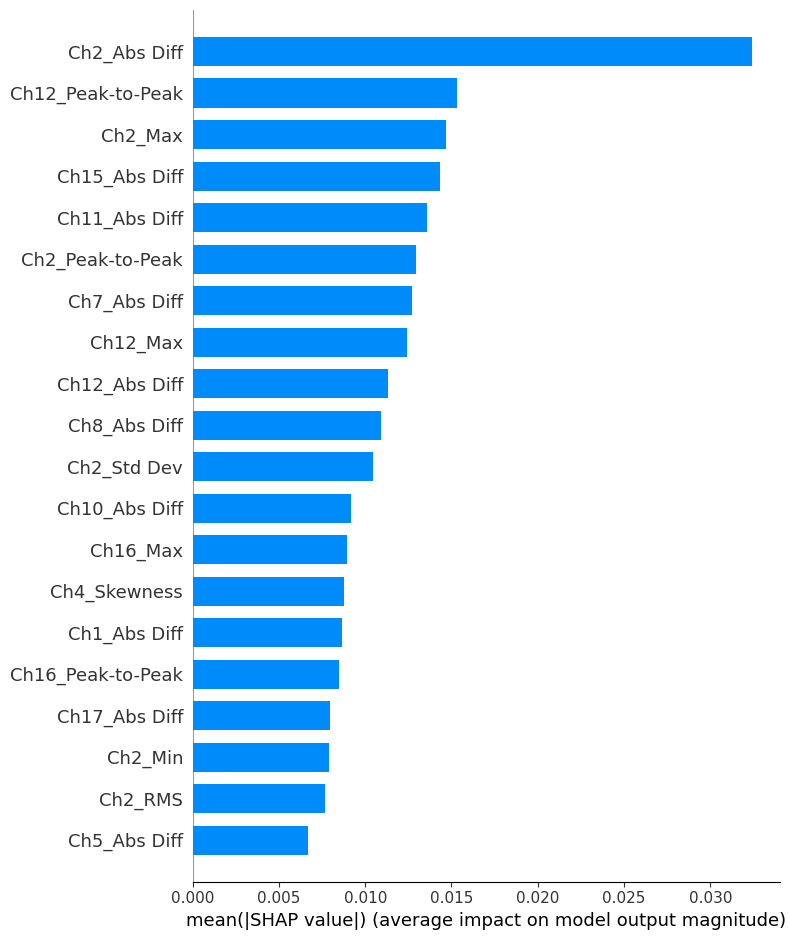

In [14]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, plot_type="bar")

# For a single prediction (local explanation)
shap.force_plot(explainer.expected_value[1], shap_values[1][idx], X_test[idx], feature_names=feature_names)


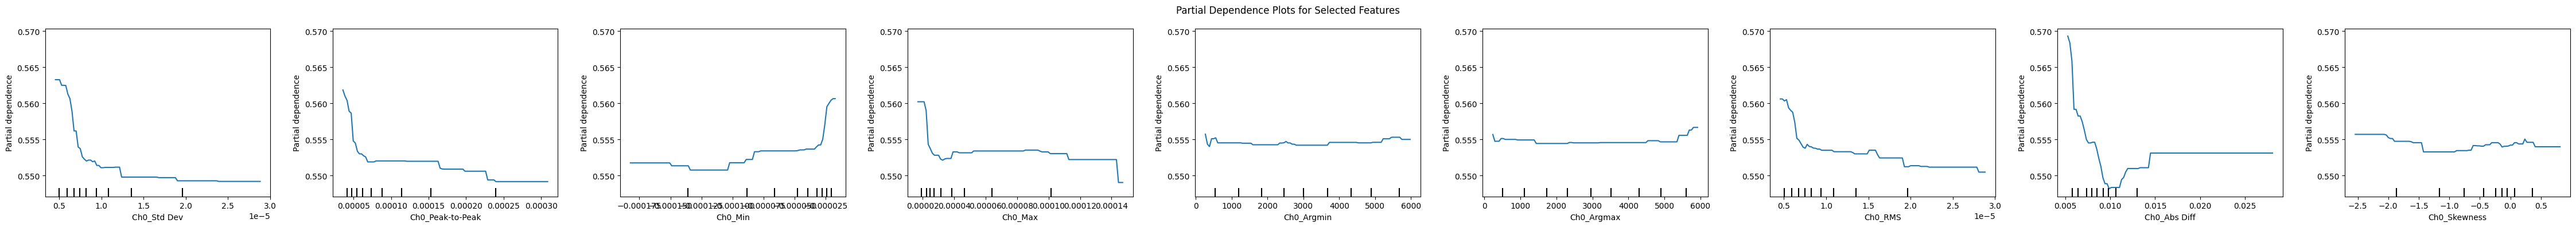

In [15]:
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Function to find constant or near-constant features
def find_constant_features(X, threshold=1e-5):
    return [i for i in range(X.shape[1]) if np.ptp(X[:, i]) < threshold]

# Example: Replace with your actual feature indices or selection logic
top_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Identify constant features in the training set
constant_features = find_constant_features(X_train)

# Filter out constant or near-constant features from top_features
filtered_features = [f for f in top_features if f not in constant_features]

# Plot PDP for the filtered features
if len(filtered_features) > 0:
    fig, ax = plt.subplots(1, len(filtered_features), figsize=(5 * len(filtered_features), 4))
    if len(filtered_features) == 1:
        ax = [ax]  # Ensure ax is iterable if only one plot
    PartialDependenceDisplay.from_estimator(
        rf_model,
        X_train,
        features=filtered_features,
        feature_names=feature_names,
        ax=ax
    )
    plt.suptitle("Partial Dependence Plots for Selected Features")
    plt.tight_layout()
    plt.show()
else:
    print("No features with sufficient variance for PDP plots.")


LOGISTIC REGRESSION

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression: {lr_acc:.2f}")


Logistic Regression: 0.84


In [56]:
import eli5
from eli5.sklearn import PermutationImportance

# Permutation importance
perm = PermutationImportance(lr_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)


In [19]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, 
    mode="classification", 
    feature_names=feature_names, 
    class_names=["Healthy", "Patient"], 
    discretize_continuous=True
)

idx = 10  # Example test index
exp = explainer.explain_instance(X_test[idx], lr_model.predict_proba, num_features=10)
exp.show_in_notebook()  # For Jupyter; use exp.as_list() for script output


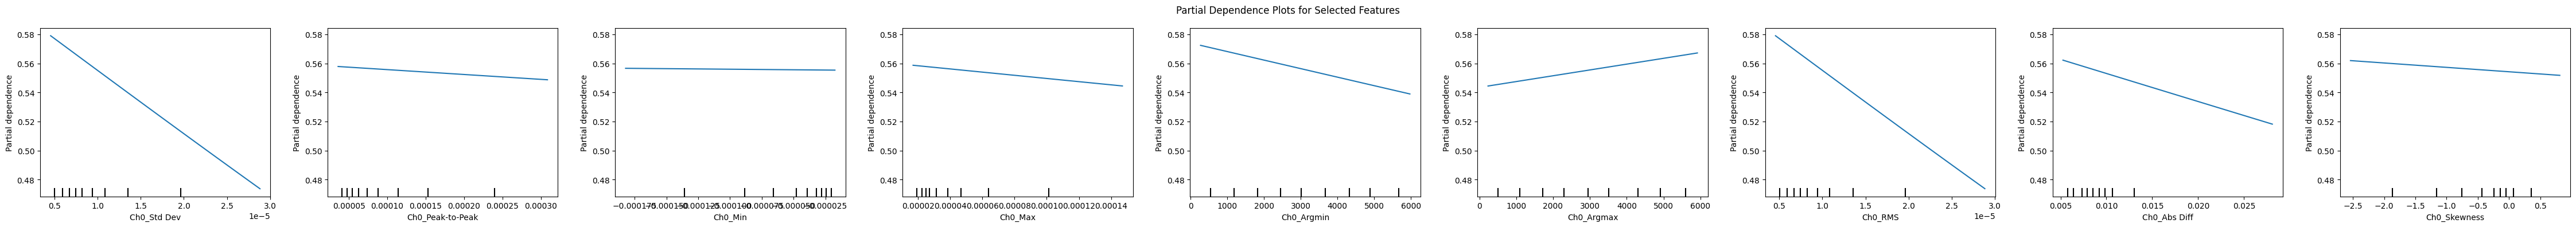

In [20]:
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import matplotlib.pyplot as plt

# Remove constant/near-constant features
def find_constant_features(X, threshold=1e-5):
    return [i for i in range(X.shape[1]) if np.ptp(X[:, i]) < threshold]

top_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Example indices
constant_features = find_constant_features(X_train)
filtered_features = [f for f in top_features if f not in constant_features]

if filtered_features:
    fig, ax = plt.subplots(1, len(filtered_features), figsize=(5 * len(filtered_features), 4))
    if len(filtered_features) == 1:
        ax = [ax]
    PartialDependenceDisplay.from_estimator(
        lr_model, X_train, features=filtered_features, feature_names=feature_names, ax=ax
    )
    plt.suptitle("Partial Dependence Plots for Selected Features")
    plt.tight_layout()
    plt.show()
else:
    print("No features with sufficient variance for PDP plots.")


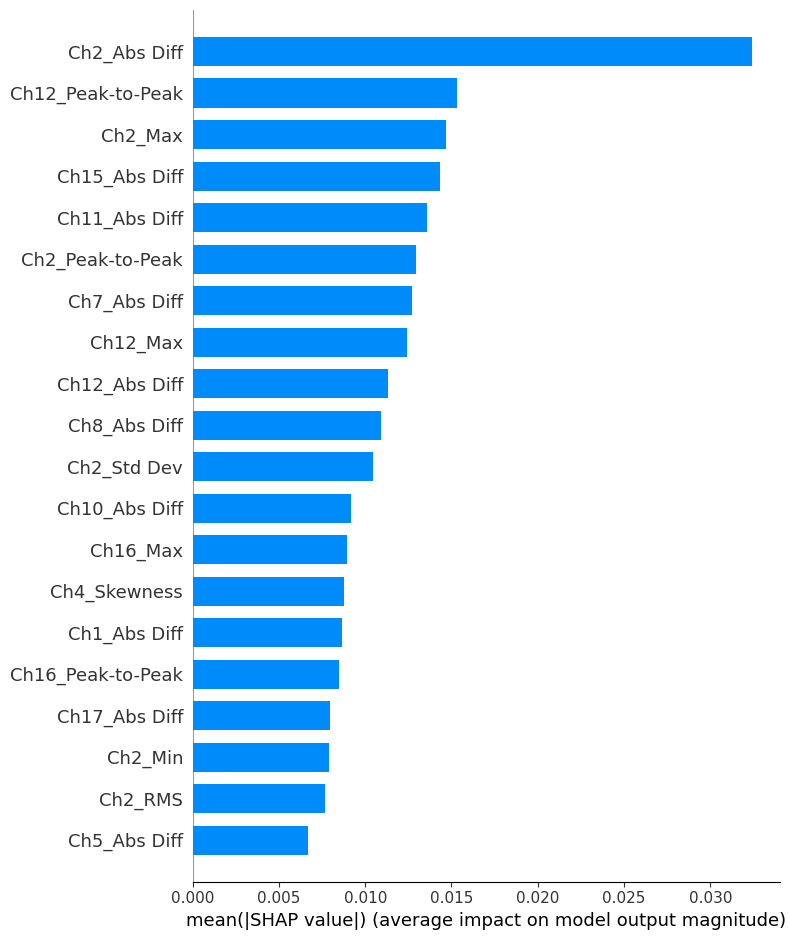

In [21]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, plot_type="bar")

# For a single prediction (local explanation)
shap.force_plot(explainer.expected_value[1], shap_values[1][idx], X_test[idx], feature_names=feature_names)


LSTM

In [58]:
import numpy as np

# Example: reshape flat features into sequences for LSTM
# Suppose each sample is divided into 'timesteps' segments, each with 'features' features
X = features  # shape: (n_samples, n_channels, n_stats)
# For LSTM, you might flatten channels × stats as features per timestep, or use channels as features and epochs as timesteps

# Example: reshape to (samples, timesteps, features)
X_lstm = X.reshape(X.shape[0], 1, -1)  # Here, 1 timestep
y_lstm = y


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5366 - loss: 0.7279 - val_accuracy: 0.5188 - val_loss: 0.6925
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4902 - loss: 0.7141 - val_accuracy: 0.5562 - val_loss: 0.6879
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5429 - loss: 0.6996 - val_accuracy: 0.5625 - val_loss: 0.6878
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5767 - loss: 0.6863 - val_accuracy: 0.5813 - val_loss: 0.6864
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5334 - loss: 0.6923 - val_accuracy: 0.5500 - val_loss: 0.6890
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5481 - loss: 0.6897 - val_accuracy: 0.5188 - val_loss: 0.6884
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5661 - loss: 0.6782 - val_accuracy: 0.5063 - val_loss: 0.6937
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5133 - loss: 0.6957 - val_accuracy: 0.5437 - val_loss: 0.6889
Ep

In [60]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM: {accuracy:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5323 - loss: 0.6933  
LSTM: 0.53


ADABOOST

In [61]:
# Flatten the feature array
X = features.reshape(features.shape[0], -1)  # Now shape is (n_samples, n_channels * n_features_per_channel)

In [62]:
import numpy as np

# Remove constant or near-constant features
non_constant_columns = [i for i in range(X.shape[1]) if np.ptp(X[:, i]) > 1e-8]
X_filtered = X[:, non_constant_columns]
filtered_feature_names = [feature_names[i] for i in non_constant_columns]


In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.3, random_state=42
)

In [64]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

base_estimator = DecisionTreeClassifier(max_depth=1)
ada_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

y_pred = ada_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoost: {accuracy:.2f}")


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


AdaBoost: 0.89


In [28]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(ada_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=filtered_feature_names)


In [29]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    mode="classification",
    feature_names=filtered_feature_names,
    class_names=["Class 0", "Class 1"],  # Adjust as needed
    discretize_continuous=True
)

idx = 10  # Example index from X_test
exp = explainer.explain_instance(X_test[idx], ada_model.predict_proba, num_features=10)
exp.show_in_notebook()


  0%|          | 0/10 [00:00<?, ?it/s]

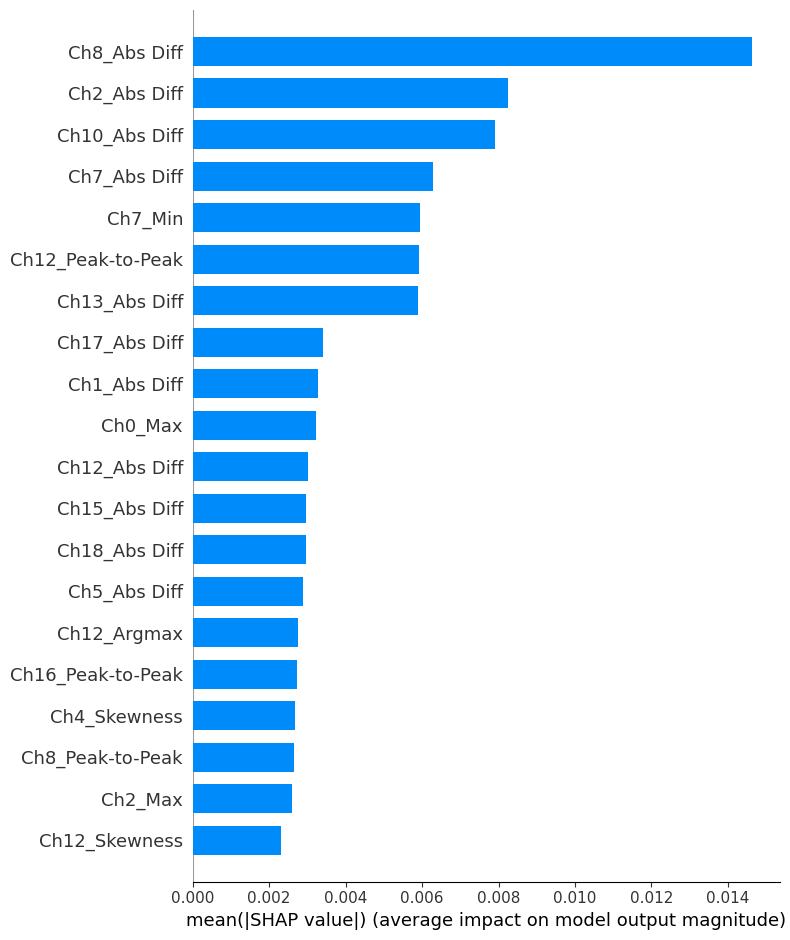

In [30]:
import shap

shap.initjs()
explainer = shap.KernelExplainer(ada_model.predict_proba, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])
shap.summary_plot(shap_values[1], X_test[:10], feature_names=filtered_feature_names, plot_type="bar")


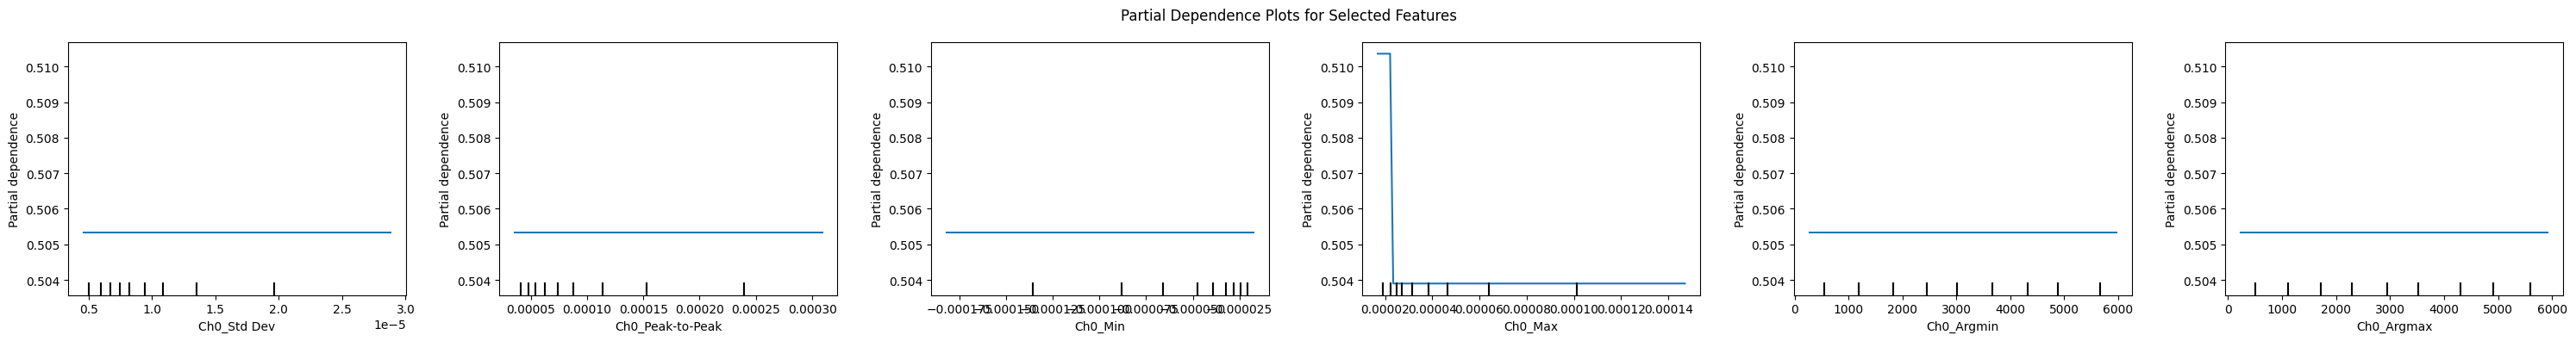

In [31]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Filter out constant/low-variance features
def find_constant_features(X, threshold=1e-5):
    return [i for i in range(X.shape[1]) if np.ptp(X[:, i]) < threshold]

top_features = [0, 1, 2, 3,4, 5, 6, 7, 8]  # Replace with your top feature indices
constant_features = find_constant_features(X_train)
filtered_features = [f for f in top_features if f not in constant_features]

if filtered_features:
    fig, ax = plt.subplots(1, len(filtered_features), figsize=(5 * len(filtered_features), 4))
    if len(filtered_features) == 1:
        ax = [ax]
    PartialDependenceDisplay.from_estimator(
        ada_model,
        X_train,
        features=filtered_features,
        feature_names=feature_names,
        ax=ax
    )
    plt.suptitle("Partial Dependence Plots for Selected Features")
    plt.tight_layout()
    plt.show()
else:
    print("No features with sufficient variance for PDP plots.")


XGBOOST

In [67]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost: {accuracy:.2f}")


XGBoost: 0.96


In [68]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=filtered_feature_names)


In [34]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    mode="classification",
    feature_names=filtered_feature_names,
    class_names=["Class 0", "Class 1"],  # Adjust as needed
    discretize_continuous=True
)

idx = 10  # Example index from X_test
exp = explainer.explain_instance(X_test[idx], xgb_model.predict_proba, num_features=10)
exp.show_in_notebook()  # For Jupyter; use exp.as_list() for script output


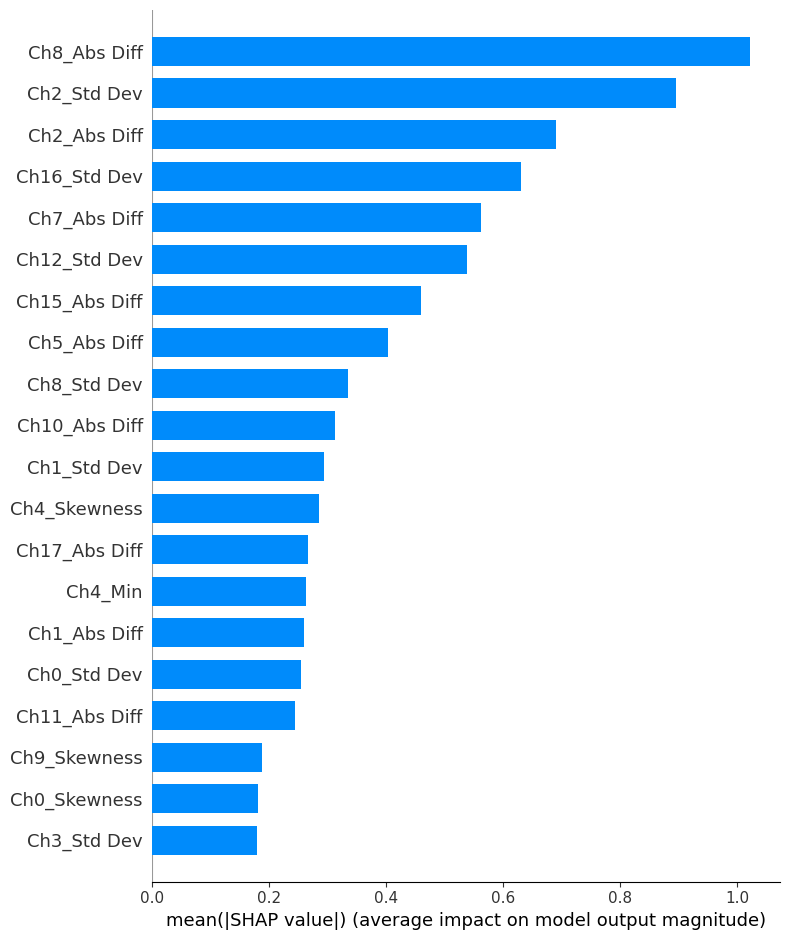

In [35]:
import shap

shap.initjs()
# For XGBoost, TreeExplainer is efficient and recommended
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Global summary plot
shap.summary_plot(shap_values, X_test, feature_names=filtered_feature_names, plot_type="bar")

# Local explanation for a single instance
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], feature_names=filtered_feature_names)


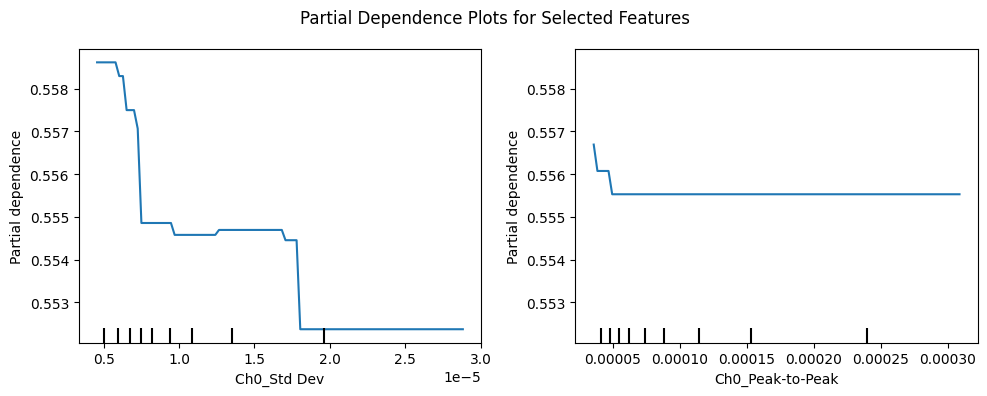

In [36]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Identify and remove constant features
def find_constant_features(X, threshold=1e-5):
    return [i for i in range(X.shape[1]) if np.ptp(X[:, i]) < threshold]

top_features = [0, 1, 2, 3]  # Replace with your top feature indices after filtering
constant_features = find_constant_features(X_train)
filtered_features = [f for f in top_features if f not in constant_features]

if filtered_features:
    fig, ax = plt.subplots(1, len(filtered_features), figsize=(5 * len(filtered_features), 4))
    if len(filtered_features) == 1:
        ax = [ax]
    PartialDependenceDisplay.from_estimator(
        xgb_model,
        X_train,
        features=filtered_features,
        feature_names=filtered_feature_names,
        ax=ax
    )
    plt.suptitle("Partial Dependence Plots for Selected Features")
    plt.tight_layout()
    plt.show()
else:
    print("No features with sufficient variance for PDP plots.")
